# 🧩 Mini-Lab: Positional Encoding Patterns

**Module 2: Understanding Large Language Models** | **Duration: ~30 min** | **Type: Mini-Lab (Brick)**

---

## Learning Objectives

By the end of this mini-lab, you will be able to:

1. **Understand** why transformers need positional encoding
2. **Visualize** sinusoidal positional encoding patterns
3. **Recognize** how different positions have unique encodings

## Target Concepts

| Concept | Description |
|---------|-------------|
| Positional Encoding | Method to inject sequence position information into transformer embeddings |

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def md(text):
    """Display text as rendered markdown."""
    display(Markdown(text))

np.set_printoptions(precision=3, suppress=True)
print("✓ Setup complete")

✓ Setup complete


## 2. The Problem: Transformers Are Order-Blind

Unlike RNNs that process tokens sequentially, transformers process all tokens in **parallel**. This is great for speed, but it means:

> "The cat sat on the mat" and "mat the on sat cat The" would look the same!

**Solution**: Add position information to each token's embedding.

In [2]:
# Demonstrate the problem
sentence1 = ["The", "cat", "sat", "on", "the", "mat"]
sentence2 = ["mat", "the", "on", "sat", "cat", "The"]

# Without position info, a bag-of-words representation is identical
print("Without position encoding:")
print(f"  Sentence 1 tokens: {sorted(sentence1)}")
print(f"  Sentence 2 tokens: {sorted(sentence2)}")
print(f"  Same set? {set(sentence1) == set(sentence2)}")

md("\n**Problem**: Pure attention treats these as identical! We need position information.")

Without position encoding:
  Sentence 1 tokens: ['The', 'cat', 'mat', 'on', 'sat', 'the']
  Sentence 2 tokens: ['The', 'cat', 'mat', 'on', 'sat', 'the']
  Same set? True



**Problem**: Pure attention treats these as identical! We need position information.

## 3. Sinusoidal Positional Encoding

The original Transformer paper uses sine and cosine functions:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

- **pos**: Position in the sequence (0, 1, 2, ...)
- **i**: Dimension index
- **d_model**: Embedding dimension

In [3]:
def sinusoidal_positional_encoding(seq_len, d_model):
    """Generate sinusoidal positional encodings."""
    positions = np.arange(seq_len)[:, np.newaxis]  # (seq_len, 1)
    dimensions = np.arange(d_model)[np.newaxis, :]  # (1, d_model)
    
    # Compute angle rates: 1 / 10000^(2i/d_model)
    angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / d_model)
    
    # Compute angles
    angles = positions * angle_rates
    
    # Apply sin to even indices, cos to odd indices
    pe = np.zeros_like(angles)
    pe[:, 0::2] = np.sin(angles[:, 0::2])  # Even dimensions
    pe[:, 1::2] = np.cos(angles[:, 1::2])  # Odd dimensions
    
    return pe

# Generate for a small example
seq_len = 10
d_model = 16

pe = sinusoidal_positional_encoding(seq_len, d_model)
print(f"Positional Encoding Shape: {pe.shape}")
print(f"\nFirst 3 positions (showing first 8 dimensions):")
print(pe[:3, :8])

Positional Encoding Shape: (10, 16)

First 3 positions (showing first 8 dimensions):
[[ 0.     1.     0.     1.     0.     1.     0.     1.   ]
 [ 0.841  0.54   0.311  0.95   0.1    0.995  0.032  1.   ]
 [ 0.909 -0.416  0.591  0.807  0.199  0.98   0.063  0.998]]


## 4. Visualizing the Encoding Patterns

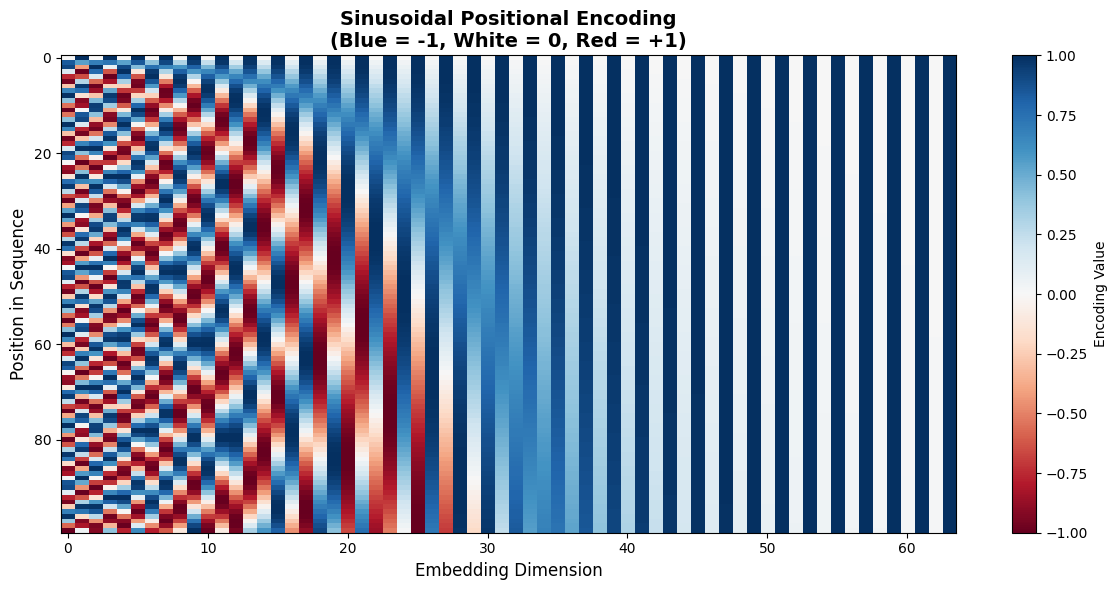


**Pattern Observations**:
- Lower dimensions (left): Faster oscillation - capture fine-grained position
- Higher dimensions (right): Slower oscillation - capture coarse position patterns
- Each row (position) has a unique "fingerprint"


In [4]:
# Generate larger encoding for visualization
seq_len = 100
d_model = 64
pe = sinusoidal_positional_encoding(seq_len, d_model)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pe, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)

ax.set_xlabel('Embedding Dimension', fontsize=12)
ax.set_ylabel('Position in Sequence', fontsize=12)
ax.set_title('Sinusoidal Positional Encoding\n(Blue = -1, White = 0, Red = +1)', 
             fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Encoding Value')
plt.tight_layout()
plt.show()

md("""
**Pattern Observations**:
- Lower dimensions (left): Faster oscillation - capture fine-grained position
- Higher dimensions (right): Slower oscillation - capture coarse position patterns
- Each row (position) has a unique "fingerprint"
""")

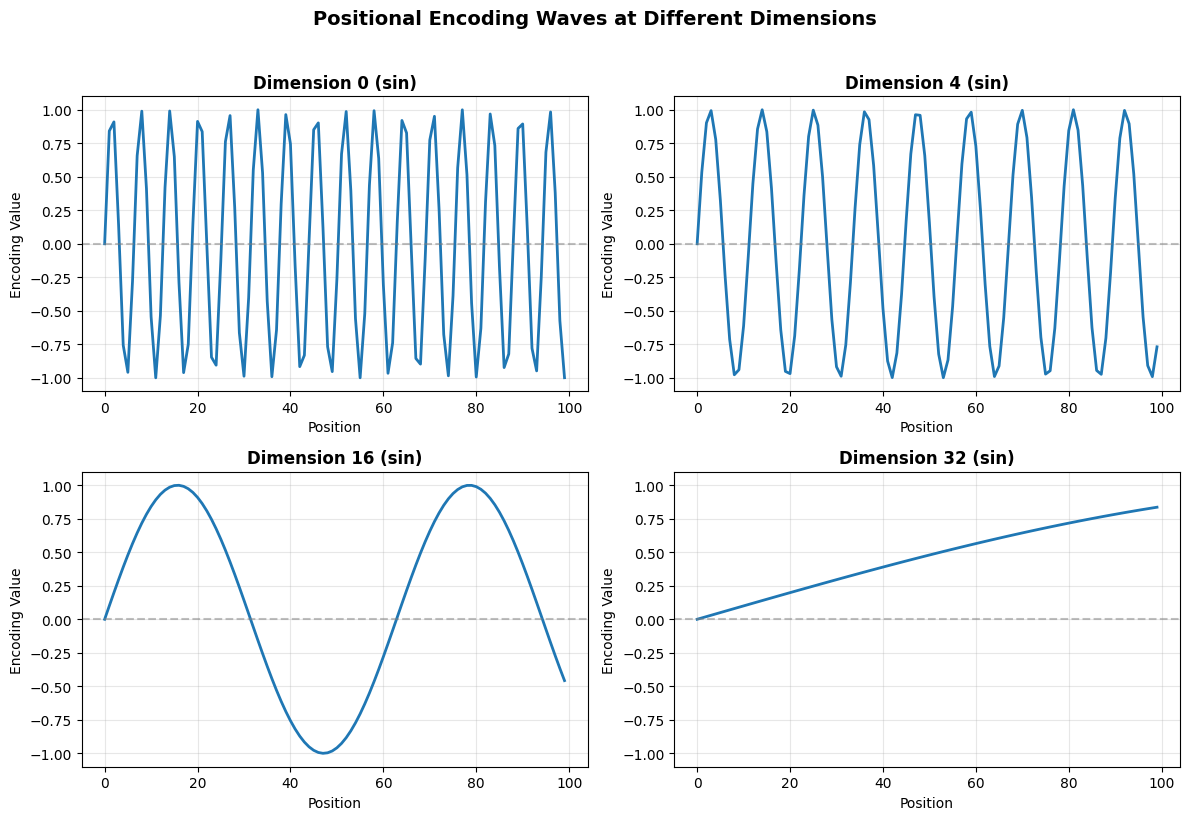

**Notice**: Lower dimensions oscillate faster, higher dimensions slower. This creates a unique signature for each position.

In [5]:
# Plot specific dimensions to see the wave patterns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

dims_to_plot = [0, 4, 16, 32]  # Different frequency dimensions
positions = np.arange(seq_len)

for ax, dim in zip(axes.flat, dims_to_plot):
    ax.plot(positions, pe[:, dim], linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Position')
    ax.set_ylabel('Encoding Value')
    ax.set_title(f'Dimension {dim} ({"sin" if dim % 2 == 0 else "cos"})', fontweight='bold')
    ax.set_ylim(-1.1, 1.1)
    ax.grid(alpha=0.3)

plt.suptitle('Positional Encoding Waves at Different Dimensions', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

md("**Notice**: Lower dimensions oscillate faster, higher dimensions slower. This creates a unique signature for each position.")

## 5. Position Uniqueness and Similarity

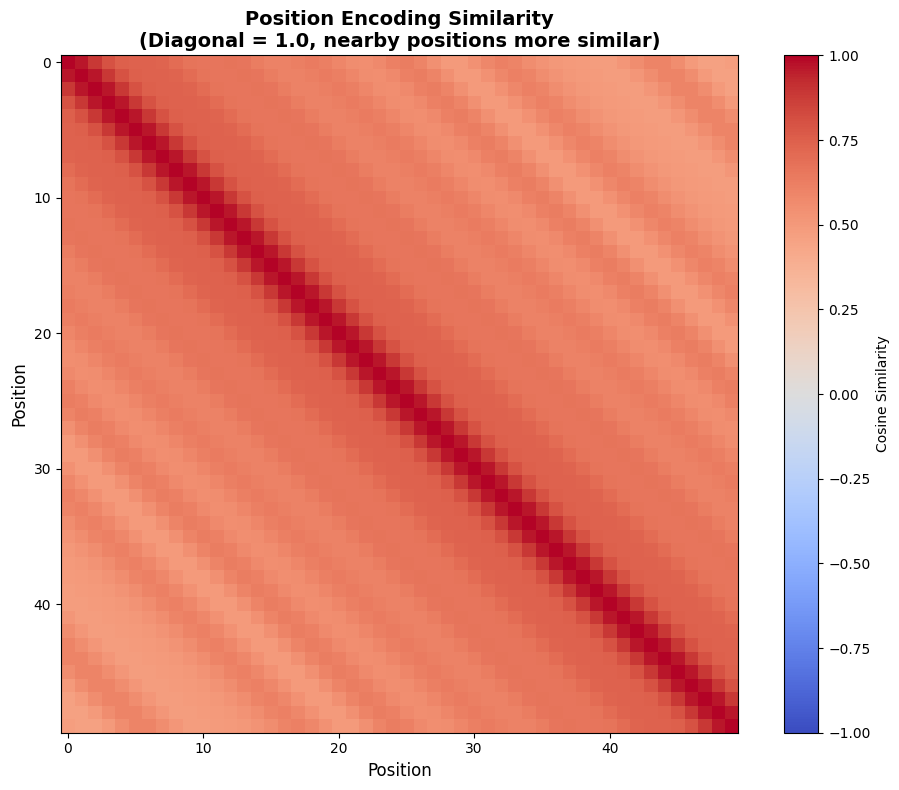


**Key Insight**: 
- The diagonal is always 1 (position similar to itself)
- Nearby positions are more similar than distant ones
- This helps the model understand relative distances


In [6]:
def position_similarity_matrix(pe):
    """Compute cosine similarity between all position encodings."""
    # Normalize each position vector
    norms = np.linalg.norm(pe, axis=1, keepdims=True)
    pe_normalized = pe / norms
    
    # Compute cosine similarity
    similarity = pe_normalized @ pe_normalized.T
    return similarity

# Compute similarity for first 50 positions
pe_50 = sinusoidal_positional_encoding(50, 64)
sim_matrix = position_similarity_matrix(pe_50)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(sim_matrix, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_title('Position Encoding Similarity\n(Diagonal = 1.0, nearby positions more similar)', 
             fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

md("""
**Key Insight**: 
- The diagonal is always 1 (position similar to itself)
- Nearby positions are more similar than distant ones
- This helps the model understand relative distances
""")

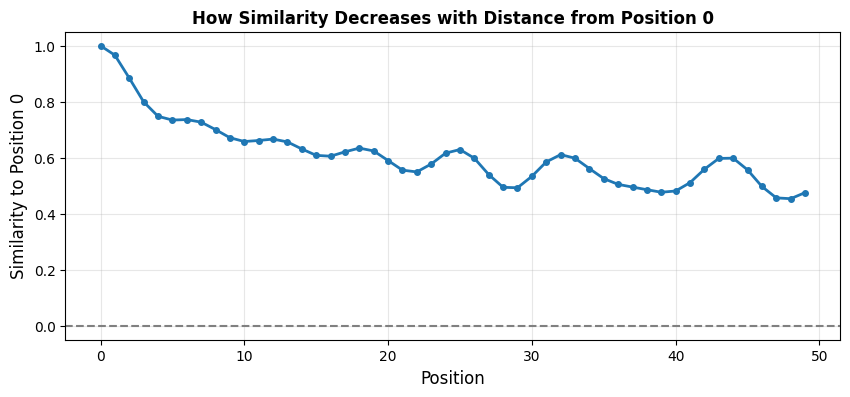

**Smooth decay**: The sinusoidal encoding creates a smooth similarity gradient, helping models understand 'nearness'.

In [7]:
# Analyze similarity drop-off
reference_pos = 0
similarities = sim_matrix[reference_pos, :]

plt.figure(figsize=(10, 4))
plt.plot(similarities, linewidth=2, marker='o', markersize=4)
plt.xlabel('Position', fontsize=12)
plt.ylabel(f'Similarity to Position {reference_pos}', fontsize=12)
plt.title(f'How Similarity Decreases with Distance from Position {reference_pos}', 
          fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

md("**Smooth decay**: The sinusoidal encoding creates a smooth similarity gradient, helping models understand 'nearness'.")

## 6. Adding Positional Encoding to Embeddings

In [8]:
def add_positional_encoding(embeddings, d_model):
    """Add positional encoding to token embeddings."""
    seq_len = embeddings.shape[0]
    pe = sinusoidal_positional_encoding(seq_len, d_model)
    return embeddings + pe

# Example: tokens with embeddings
tokens = ["The", "cat", "sat", "on", "the", "mat"]
d_model = 8

# Simulate token embeddings (in practice, from embedding layer)
np.random.seed(42)
token_embeddings = np.random.randn(len(tokens), d_model) * 0.1

# Add positional encoding
position_encoded = add_positional_encoding(token_embeddings, d_model)

print("Token Embeddings (first 4 dims):")
for i, token in enumerate(tokens):
    print(f"  {token:4s}: {token_embeddings[i, :4]}")

print("\n+ Positional Encoding (first 4 dims):")
pe = sinusoidal_positional_encoding(len(tokens), d_model)
for i in range(len(tokens)):
    print(f"  pos {i}: {pe[i, :4]}")

print("\n= Final Embeddings (first 4 dims):")
for i, token in enumerate(tokens):
    print(f"  {token:4s}: {position_encoded[i, :4]}")

Token Embeddings (first 4 dims):
  The : [ 0.05  -0.014  0.065  0.152]
  cat : [-0.047  0.054 -0.046 -0.047]
  sat : [-0.101  0.031 -0.091 -0.141]
  on  : [-0.054  0.011 -0.115  0.038]
  the : [-0.001 -0.106  0.082 -0.122]
  mat : [ 0.074  0.017 -0.012 -0.03 ]

+ Positional Encoding (first 4 dims):
  pos 0: [0. 1. 0. 1.]
  pos 1: [0.841 0.54  0.1   0.995]
  pos 2: [ 0.909 -0.416  0.199  0.98 ]
  pos 3: [ 0.141 -0.99   0.296  0.955]
  pos 4: [-0.757 -0.654  0.389  0.921]
  pos 5: [-0.959  0.284  0.479  0.878]

= Final Embeddings (first 4 dims):
  The : [0.05  0.986 0.065 1.152]
  cat : [0.795 0.595 0.053 0.948]
  sat : [ 0.808 -0.385  0.108  0.839]
  on  : [ 0.087 -0.979  0.18   0.993]
  the : [-0.758 -0.759  0.472  0.799]
  mat : [-0.885  0.301  0.468  0.847]


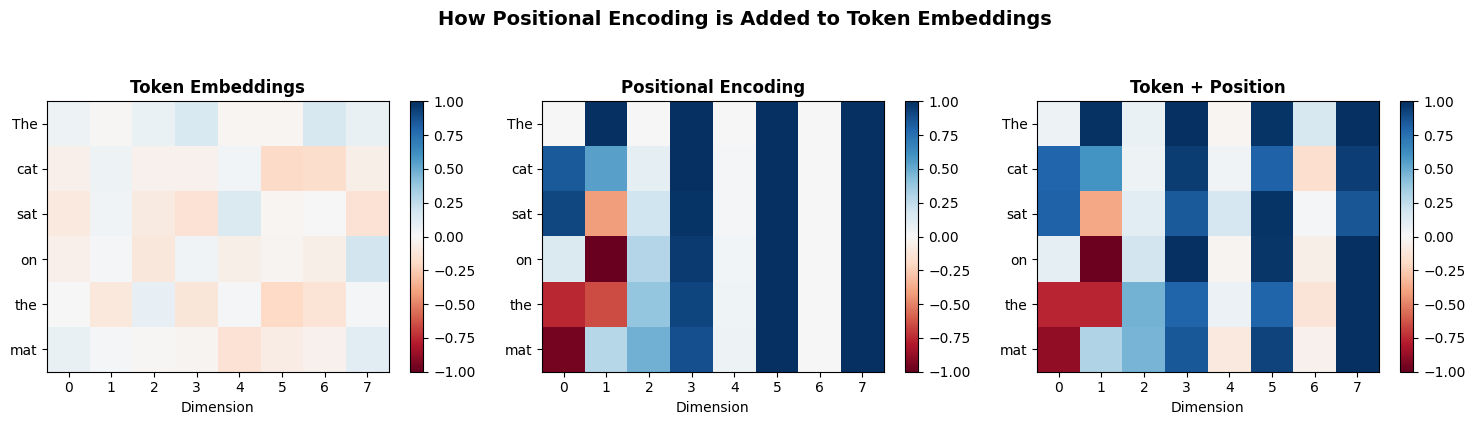

In [9]:
# Visualize the addition
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

data = [token_embeddings, pe, position_encoded]
titles = ['Token Embeddings', 'Positional Encoding', 'Token + Position']

for ax, d, title in zip(axes, data, titles):
    im = ax.imshow(d, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Dimension')
    ax.set_title(title, fontweight='bold')
    plt.colorbar(im, ax=ax)

plt.suptitle('How Positional Encoding is Added to Token Embeddings', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## 🎯 Summary

### Key Takeaways

1. **Why**: Transformers process tokens in parallel - they can't tell position without help
2. **How**: Sinusoidal functions create unique "fingerprints" for each position
3. **Addition**: Position encodings are simply added to token embeddings
4. **Properties**: Nearby positions are more similar, enabling relative position understanding

### Types of Positional Encoding

| Type | Used By | Trainable? | Key Property |
|------|---------|------------|-------------|
| Sinusoidal | Original Transformer | No | Generalizes to longer sequences |
| Learned | BERT, GPT-2 | Yes | Optimized for training data |
| Rotary (RoPE) | LLaMA, GPT-NeoX | No | Encodes relative positions |
| ALiBi | BLOOM | No | Attention-based, no embedding needed |
